서비스 이탈예측 데이터
데이터 설명 : 고객의 신상정보 데이터를 통한 회사 서비스 이탈 예측 (종속변수 : Exited)
일반적 :0이 이탈하지않을고객(유지)
        1이 이탈예상 고객

In [ ]:
import pandas as pd
X_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/y_train.csv")
X_test  = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_test.csv")

In [ ]:
X_train.select_dtypes(exclude='object')

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15799217,791,35,7,52436.20,1,1,0,161051.75
1,15748986,705,42,8,166685.92,2,1,1,55313.51
2,15722004,543,31,4,138317.94,1,0,0,61843.73
3,15780966,709,32,2,0.00,2,0,0,109681.29
4,15636731,714,36,1,101609.01,2,1,1,447.73
...,...,...,...,...,...,...,...,...,...
6494,15702806,696,24,9,0.00,1,0,0,10883.52
6495,15674179,513,34,7,60515.13,1,0,0,124571.09
6496,15790204,663,22,9,0.00,1,1,0,29135.89
6497,15690772,635,48,2,0.00,2,1,1,136551.25


In [ ]:
X_train['Gender'] = X_train['Gender'].str.strip().str.lower()
X_train['Gender'].value_counts()

,count
Gender,
male,3565
female,2934


In [ ]:
#필요없는칼럼 지우기
X_train = X_train.drop(['CustomerId','Surname'], axis=1)
X_test = X_test.drop('Surname', axis=1)
X_test_id = X_test.pop('CustomerId')
y_train = y_train.drop('CustomerId', axis=1)  #-> 이건 y의 target값만 뽑을거니까 그냥 drop안하고 냅둬도 무방함
#타겟변수 추출
target = y_train['Exited']

# # # X_train.describe()

# #Balance , EstimatedSalary 스켈링 격차가 넘큼
# 3. 스케일링
col = ['Balance', 'EstimatedSalary']
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[col] = scaler.fit_transform(X_train[col])
X_test[col] = scaler.transform(X_test[col])

# # print(X_train.shape, X_test.shape)

# #ㅁ인코딩
# X_train.select_dtypes(include='object').describe()

# X_train['Gender'].value_counts()

# # male을 Male로 female을 Female로 바꿔주자
# # strip()을 반드시 써야하는이유 그냥 str.lower.replace만하면 단어에 공백이있는경우 male이 두개가 생김 이데이터가 그럼, 이걸 해결하려면 str.strip=앞뒤공백제거를 반드시 해줘야함
X_train['Gender'] = X_train['Gender'].str.strip().str.lower().replace({'Female' : 'female', 'Male' : 'male'}) #앞에 이미 lower를 해서 replace를 굳이 안써도됨 lower()까지만 하면 끝
X_test['Gender'] = X_test['Gender'].str.strip().str.lower().replace({'Female' : 'female', 'Male' : 'male'})
X_train['Gender'].value_counts()

# #ㅁ인코딩
X_train = pd.get_dummies(X_train).astype(int)
X_test = pd.get_dummies(X_test).astype(int)

#원핫인코딩 후 아래 한줄을 반드시 정석으로 해줘야 문제가 없다
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


X_train.head()

#ㅁ데이터 스플릿
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train,
                                            target,
                                            test_size = 0.2,
                                            random_state = 2025)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

#범주형 문제-> 분류 모델선택
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=2025,class_weight='balanced',max_depth=5, n_estimators = 100)
model.fit(X_tr,y_tr)
pred = model.predict(X_val)
pred_proba = model.predict_proba(X_val)[:,1]

#평가 및 확인 f1등 분류지표사용
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
print(f1_score(y_val, pred))
print(recall_score(y_val, pred))
print(precision_score(y_val, pred))
print(roc_auc_score(y_val, pred_proba))


#기본 -> f1_score와 roc_auc를 높이는것이 목표가 되어야함
# 0.6096491228070176 ->f1score
# 0.5129151291512916 ->recall
# 0.7513513513513513 ->precision
# 0.8495852742783987 ->roc_auc 0의 값
# 0.7471195120114467 ->roc_auc 1의 값 ->우린 이탈고객을예측하는것이므로 이게 중요

#하이퍼 파라미터 조정 random_state=2025,class_weight='balanced' 추가 ->Calss_weight하면 클래스 불균형이 조정되어 나와서 기존 0과 1로 나뉘어던 성능이 합쳐져서 나타남! 즉 성능이 올라감 -> 이탈고객에게 더 높은 가중치부여
# 0.6096491228070176
# 0.5129151291512916
# 0.7513513513513513
# 0.8495852742783987 ->roc_auc 통합 성능 값

#max_depth=5 추가 -> recall이 크게향상됨(더 많은 이탈고객을 찾아냄) but precision감소(FP는 증가)
# 0.6037735849056604
# 0.7675276752767528
# 0.49760765550239233
# 0.868815422848106

#n_estimators 추가 -> 이는 class_weight='balanced'와 n_estimators 조합이 재현율을 높이는 방향으로 모델을 조정했음을 의미합니다!
# 0.6037735849056604
# 0.7675276752767528
# 0.49760765550239233
# 0.868815422848106
# 0.868815422848106



#ㅁtest 데이터로 찐 진행 -> 제출형식이 확률이아닌 0/1이기 때문에 pred_proba로하면안됨!! pred로 해야함
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)


result = pd.DataFrame({
                       'ID' : X_test_id,
                       'Exited' : pred
})

result.to_csv('24123.csv',index=False)




0.6037735849056604
0.7675276752767528
0.49760765550239233
0.868815422848106


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
#roc_auc정리
#roc_auc는 무조건 pred_proba를 써야함 -> But!!!! 이진분류일경우
#만약 roc_auc가 다중분류일 경우 ex 1234로 예측해라 ->
# pred_proba = model.predict_proba(X_val)[:, 1] 하고 밑에 print할때는
#roc_auc_score(y_val, pred_proba, multiclass= 'ovr', average='macro') 이렇게 해야함

#macro정리
#macro는 다중분류일떄만 쓰고 f1_score에만 하나쓰는게 아닌 전체적으로 통일해서 써줘야함!
#그리고

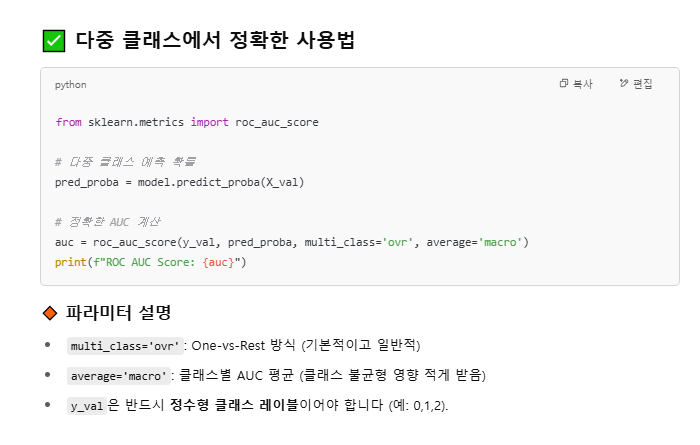

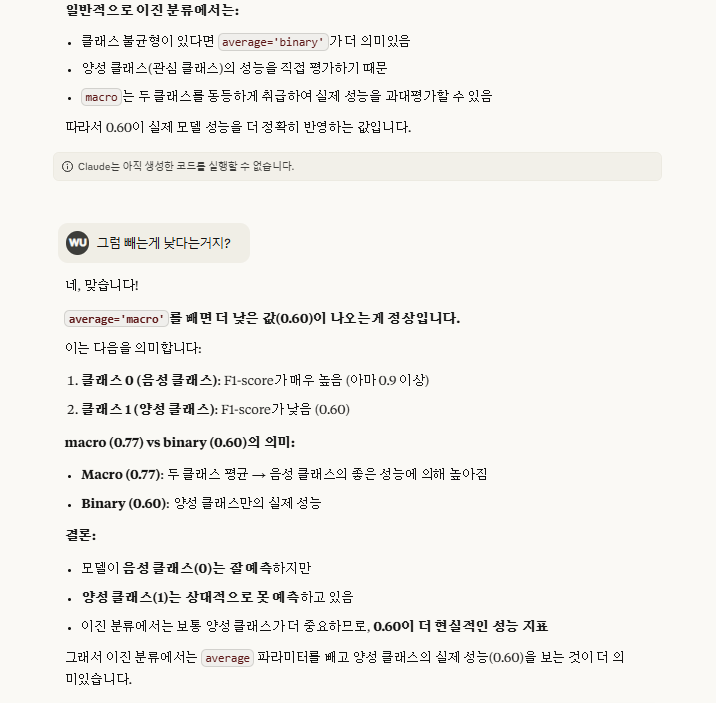

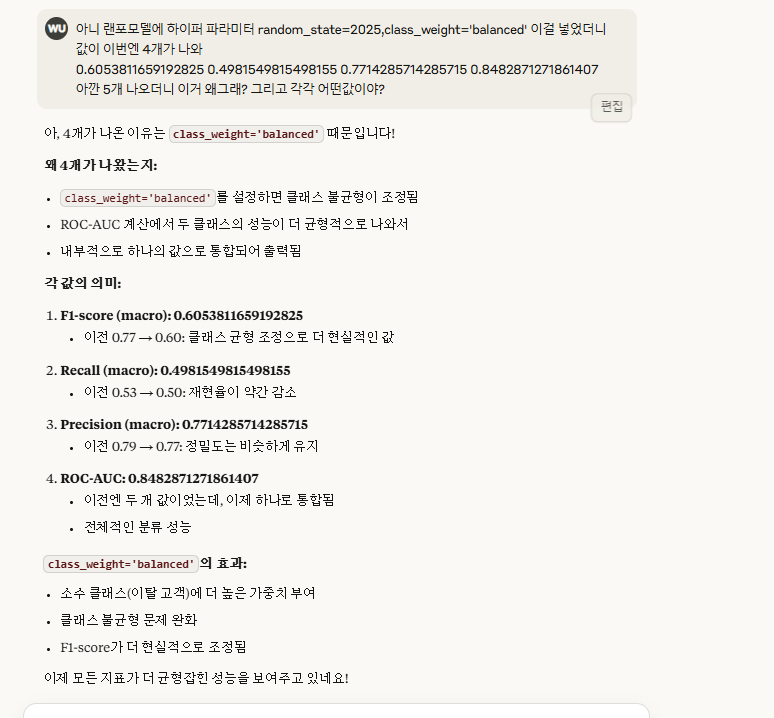

,count
Gender,
male,3565
female,2934


In [ ]:
y_train.head()

,CustomerId,Exited
0,15799217,0
1,15748986,0
2,15722004,0
3,15780966,0
4,15636731,0


위 문제를 쳇지피티와 핑퐁해서만든 최종본

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

# 1. 데이터 로드
X_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/y_train.csv")
X_test = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_test.csv")

# 2. 불필요한 컬럼 제거
X_test_id = X_test.pop('CustomerId')
X_train = X_train.drop(['CustomerId', 'Surname'], axis=1)
X_test = X_test.drop(['Surname'], axis=1)
target = y_train['Exited']

# 3. 범주형 전처리 - Gender 통일
X_train['Gender'] = X_train['Gender'].str.strip().str.lower()
X_test['Gender'] = X_test['Gender'].str.strip().str.lower()

# 4. 스케일링 - 수치형 변수 정규화
scale_cols = ['Balance', 'EstimatedSalary']
scaler = RobustScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

# 5. 범주형 → 원-핫 인코딩
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# 6. 컬럼 정렬 일치 (중요!)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 7. 학습/검증 분리
X_tr, X_val, y_tr, y_val = train_test_split(
                                            X_train,
                                            target,
                                            test_size=0.2,
                                            random_state=2025)

# 8. 모델 학습
model = RandomForestClassifier(
    random_state=2025,
    class_weight='balanced',
    max_depth=5,
    n_estimators=100
)
model.fit(X_tr, y_tr)

# 9. 검증 성능 평가
pred_val = model.predict(X_val)
pred_proba_val = model.predict_proba(X_val)[:, 1]

print("✅ 검증 성능")
print("F1 Score:", f1_score(y_val, pred_val))
print("Recall:", recall_score(y_val, pred_val))
print("Precision:", precision_score(y_val, pred_val))
print("ROC AUC:", roc_auc_score(y_val, pred_proba_val))

# 10. 테스트 데이터 예측
pred_test = model.predict(X_test)

# 11. 제출 파일 생성
submission = pd.DataFrame({
    'CustomerId': X_test_id,
    'Exited': pred_test
})
submission.to_csv('final_submission.csv', index=False)


✅ 검증 성능
F1 Score: 0.6078147612156295
Recall: 0.7749077490774908
Precision: 0.5
ROC AUC: 0.8738807067370965


In [ ]:
import pandas as pd

# 데이터 로드
X_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/X_train.csv")
y_train = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/churnk/y_train.csv")

# Balance = 0 여부 컬럼 추가
X_train['BalanceIsZero'] = (X_train['Balance'] == 0).astype(int)

# Balance = 0 여부와 Exited 결합
df = X_train.merge(y_train, on='CustomerId')

# 그룹별 이탈률(평균)과 수 (count) 계산
balance_churn = df.groupby('BalanceIsZero')['Exited'].agg(['mean', 'count'])
balance_churn.index = ['Balance > 0', 'Balance = 0']
balance_churn.columns = ['Exited_Rate (이탈률)', 'Count (고객 수)']

print("✅ Balance별 이탈률 비교:")
print(balance_churn)


✅ Balance별 이탈률 비교:
             Exited_Rate (이탈률)  Count (고객 수)
Balance > 0           0.238827          4162
Balance = 0           0.141207          2337


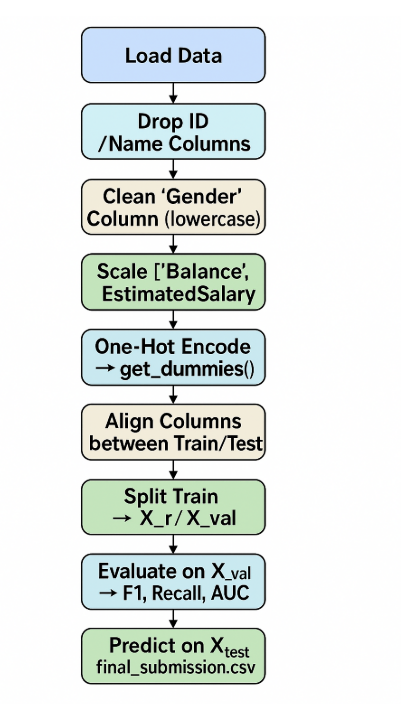